In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
import json
import plotly.graph_objects as go

In [2]:
# const
POND_NAME = 'yinchuan_1'
SURFACE_TEMPERATURE = 24.0

# enum "fromXlsxFolder/from2001Folder"
class WhichDataFolder(Enum):
    fromXlsxFolder = 1
    from2001Folder = 2

WhereGetEnum:WhichDataFolder = WhichDataFolder.fromXlsxFolder
WhereGetMap:WhichDataFolder = WhichDataFolder.fromXlsxFolder

# 处理地形

In [3]:
class Material(Enum):
    WATER = 0
    WATER_GRASS = 1
    STONE = 2
    DRIFTWOOD = 3
    PIER = 4
    GROUND = 5

class FishType(Enum):
    BUFFALO_FISH = 0
    YELLOW_PERCH = 1
    REDEAR_SUNFISH = 2

# 映射表头到枚举值
material_mapping = {
    'Water': Material.WATER,
    'Water Grass': Material.WATER_GRASS,
    'Stone': Material.STONE,
    'Driftwood': Material.DRIFTWOOD,
    'Pier': Material.PIER,
    'Ground': Material.GROUND
}

fish_mapping = {
    '水牛鱼': FishType.BUFFALO_FISH,
    '小冠太阳鱼': FishType.REDEAR_SUNFISH,
    '黄金鲈': FishType.YELLOW_PERCH
}

# 反向映射枚举值到表头
reverse_material_mapping = {v: k for k, v in material_mapping.items()}
reverse_fish_mapping = {v: k for k, v in fish_mapping.items()}

material_color_mapping = {
    Material.WATER.value: 'blue',
    Material.WATER_GRASS.value: 'green',
    Material.STONE.value: 'white',
    Material.DRIFTWOOD.value: 'brown',
    Material.PIER.value: 'black',
    Material.GROUND.value: 'rgba(0,0,0,0)'  # 使用 'rgba(0,0,0,0)' 表示透明
}

fishTypeCount = FishType.__len__()
noFishIndex = fishTypeCount
print(f'钓空/无鱼权重将被插入到第{noFishIndex}个位置')

# material_df = pd.read_excel('exampleTables/exampleData.xlsx', sheet_name='material', index_col=0)
# environment_df = pd.read_excel('exampleTables/exampleData.xlsx', sheet_name='environment', index_col=0)
# pond_df = pd.read_excel('exampleTables/exampleData.xlsx', sheet_name='pond', index_col=0)
# bait_df = pd.read_excel('exampleTables/exampleData.xlsx', sheet_name='bait')

# column name consts
N_FAV_TEMPERATURE = "喜好水温"
N_COEF_TEMPERATURE = "水温-权重衰减系数"
N_FAV_OXYGEN = "喜好含氧量"
N_COEF_OXYGEN = "含氧量-权重衰减系数"
N_VISUAL_LOW = "视觉低光阈值"
N_COEF_SMELL = "嗅觉衰减系数"
N_SMELL_MAX = "嗅觉最大距离"
N_PROB_SCORE_BASELINE = "基准权重"

钓空/无鱼权重将被插入到第3个位置


In [4]:
def plot_numpy_3d_colors(data: np.ndarray, colors: dict, sizeScale: float = 10.0):
    fig = go.Figure()
    
    # 修正 np.arange 的用法
    x_range = np.arange(data.shape[0])
    y_range = np.arange(data.shape[1])
    z_range = np.arange(data.shape[2])

    # 使用 np.meshgrid 创建网格点
    x_points, y_points, z_points = np.meshgrid(x_range, y_range, z_range, indexing='ij')
    x_points = x_points.flatten()
    y_points = y_points.flatten()
    z_points = z_points.flatten()
    
    # 映射颜色
    color_points = np.array([colors[data[x, y, z]] for x, y, z in zip(x_points, y_points, z_points)], dtype=str)
    color_points = color_points.flatten()

    # 添加点到图形中
    fig.add_trace(go.Scatter3d(
        x=x_points,
        y=y_points,
        z=z_points,
        mode='markers',
        marker=dict(
            size=5,
            color=color_points,  # 使用 color_points 来映射颜色
            opacity=0.5  # 设置全局透明度
        )
    ))

    # 设置布局
    fig.update_layout(
        scene=dict(
            xaxis=dict(nticks=10, range=[0, data.shape[0]]),
            yaxis=dict(nticks=10, range=[0, data.shape[1]]),
            zaxis=dict(nticks=5, range=[data.shape[2], 0]),
            aspectmode='manual',
            aspectratio=dict(x=data.shape[0]/sizeScale, y=data.shape[1]/sizeScale, z=data.shape[2]/sizeScale)
        ),
        width=800,
        height=800,
        margin=dict(r=20, l=10, b=10, t=10)
    )

    # 显示图形
    fig.show()

def plotViridis(data: np.ndarray, materials:np.ndarray, upperLimit:float ,sizeScale: float = 10.0):
    fig = go.Figure()
    
    # 修正 np.arange 的用法
    x_range = np.arange(data.shape[0])
    y_range = np.arange(data.shape[1])
    z_range = np.arange(data.shape[2])

    # 使用 np.meshgrid 创建网格点
    x_grid, y_grid, z_grid = np.meshgrid(x_range, y_range, z_range, indexing='ij')
    mask = materials != Material.GROUND.value

    x_points = x_grid[mask]
    y_points = y_grid[mask]
    z_points = z_grid[mask]
    color_points = data[mask]/upperLimit
    
    fig.add_trace(go.Scatter3d(
        x=x_points,
        y=y_points,
        z=z_points,
        mode='markers',
        marker=dict(
            size=5,
            color=color_points,  # 使用 color_points 来映射颜色
            colorscale='Viridis',
            opacity=0.5  # 设置全局透明度
        )
    ))

    # 设置布局
    fig.update_layout(
        scene=dict(
            xaxis=dict(nticks=10, range=[0, data.shape[0]]),
            yaxis=dict(nticks=10, range=[0, data.shape[1]]),
            zaxis=dict(nticks=5, range=[data.shape[2], 0]),
            aspectmode='manual',
            aspectratio=dict(x=data.shape[0]/sizeScale, y=data.shape[1]/sizeScale, z=data.shape[2]/sizeScale)
        ),
        width=800,
        height=800,
        margin=dict(r=20, l=10, b=10, t=10)
    )
    fig.show()

def plotGreys(data: np.ndarray, materials:np.ndarray, upperLimit:float ,sizeScale: float = 10.0):
    fig = go.Figure()
    
    # 修正 np.arange 的用法
    x_range = np.arange(data.shape[0])
    y_range = np.arange(data.shape[1])
    z_range = np.arange(data.shape[2])

    # 使用 np.meshgrid 创建网格点
    x_grid, y_grid, z_grid = np.meshgrid(x_range, y_range, z_range, indexing='ij')
    mask = materials != Material.GROUND.value

    x_points = x_grid[mask]
    y_points = y_grid[mask]
    z_points = z_grid[mask]
    color_points = data[mask]/upperLimit
    
    fig.add_trace(go.Scatter3d(
        x=x_points,
        y=y_points,
        z=z_points,
        mode='markers',
        marker=dict(
            size=5,
            color=color_points,  # 使用 color_points 来映射颜色
            colorscale='Greys',
            opacity=0.5  # 设置全局透明度
        )
    ))

    # 设置布局
    fig.update_layout(
        scene=dict(
            xaxis=dict(nticks=10, range=[0, data.shape[0]]),
            yaxis=dict(nticks=10, range=[0, data.shape[1]]),
            zaxis=dict(nticks=5, range=[data.shape[2], 0]),
            aspectmode='manual',
            aspectratio=dict(x=data.shape[0]/sizeScale, y=data.shape[1]/sizeScale, z=data.shape[2]/sizeScale)
        ),
        width=800,
        height=800,
        margin=dict(r=20, l=10, b=10, t=10)
    )
    fig.show()
    

In [5]:
with open('map_OL2.0_v1_159x64.json', 'r') as f:
    map_data = json.load(f)

mapDatas = map_data['mapDatas']

# 探寻最大水深
maxDepth = 0
maxX = 0
maxY = 0

for rows in mapDatas:
    for item in rows:
        maxDepth = max(maxDepth, item['waterDepth'])
        maxX = max(maxX, item['x'])
        maxY = max(maxY, item['y'])

# 定义湖的尺寸
map_length = maxX + 1  # x方向的长度
map_width = maxY + 1  # y方向的宽度
map_depth = maxDepth    # z方向的深度

print(f'湖的尺寸为 {map_length} x {map_width} x {map_depth}')

湖的尺寸为 159 x 64 x 5


In [6]:
material_np = np.full((map_length, map_width, map_depth), Material.GROUND.value, dtype=int)
max_depth_np = np.full((map_length, map_width), np.inf, dtype=float)

for rows in mapDatas:
    for item in rows:
        x = item['x']
        y = item['y']
        depth = item['waterDepth']
        # 先初始化成2d编辑器编出来的material
        max_depth_np[x][y] = depth
        if depth == 0:
            max_depth_np[x][y] = np.inf
        for i in range(depth):
            material_np[x][y][i] = Material.WATER.value
        # 如果有表面物体，就直通到水底
        if item['surfaceType'] != 0:
            for i in range(0, depth):
                material_np[x][y][i] = item['surfaceType']
        # bottom barriers
        if item['underWaterType'] != 0:
            material_np[x][y][depth-1] = item['underWaterType']

# plot_numpy_3d_colors(material_np, material_color_mapping, 10.0)

# Process fish config DATA

## fish quality list and env aff list

In [7]:
pondListDf = pd.read_excel('configs/xlsx_channel/2001/fish_pond.xlsx', sheet_name='PondList', header=1, skiprows=[2,3])
pondListDf.head()


,id,name,pond_name,pond_img,map_id,fish_stock_id,entry_level,entry_item,entry_fee,open_spot_list,open_spot_list.1,open_spot_list.2,hypolimnion_t,mark
0,301020000,yinchuan_1,yinchuan_1,picture_scene_1,map_base_1,fish_stock_all,1,item_currency_coins,10,1.0,NaN,NaN,120,金币
1,301020001,yinchuan_2,yinchuan_2,picture_scene_2,map_base_2,fish_stock_all,2,item_currency_coins,100,NaN,2.0,3.0,120,金币


In [8]:
theStockId = pondListDf.loc[pondListDf['name'] == 'yinchuan_1', 'fish_stock_id'].values[0]
print(theStockId)

fish_stock_all


In [9]:
fishReleaseDf = pd.read_excel('configs/xlsx_channel/2001/fish_pond.xlsx', sheet_name='FishRelease', header=1, skiprows=[2,3])
fishReleaseDf.head()


,id,stock_id,fish_id,fish_num,prob_weight_ideal,min_env_coeff,min_adapt_coeff,length_min,length_max,is_reduce
0,1,fish_stock_all,Fish_Largemouth_Bass_Young,988,988,NaN,NaN,10,25,[表达式]否
1,2,fish_stock_all,Fish_Largemouth_Bass_Common,292,292,NaN,NaN,25,40,[表达式]否
2,3,fish_stock_all,Fish_Largemouth_Bass_Trophy,48,48,NaN,NaN,40,50,[表达式]否
3,4,fish_stock_all,Fish_Largemouth_Bass_Unique,9,9,NaN,NaN,50,74,[表达式]否
4,5,fish_stock_all,Fish_Spotted_Bass_Young,1179,1179,NaN,NaN,10,17,[表达式]否


In [10]:
fishReleaseDf = fishReleaseDf[fishReleaseDf['stock_id'] == theStockId]
print(fishReleaseDf.count())

fishReleaseDf.drop(columns=['stock_id', 'id', 'fish_num', 'is_reduce'], inplace=True)
# make NaN to 0
fishReleaseDf.fillna(0, inplace=True)

print(fishReleaseDf.head())

id                   58
stock_id             58
fish_id              58
fish_num             58
prob_weight_ideal    58
min_env_coeff         0
min_adapt_coeff       0
length_min           58
length_max           58
is_reduce            58
dtype: int64
                       fish_id  prob_weight_ideal  min_env_coeff  \
0   Fish_Largemouth_Bass_Young                988            0.0   
1  Fish_Largemouth_Bass_Common                292            0.0   
2  Fish_Largemouth_Bass_Trophy                 48            0.0   
3  Fish_Largemouth_Bass_Unique                  9            0.0   
4      Fish_Spotted_Bass_Young               1179            0.0   

   min_adapt_coeff  length_min  length_max  
0              0.0          10          25  
1              0.0          25          40  
2              0.0          40          50  
3              0.0          50          74  
4              0.0          10          17  


In [11]:
fishNames = fishReleaseDf['fish_id'].unique()
print(fishNames.shape) 

print(fishNames[0])


(58,)
Fish_Largemouth_Bass_Young


In [12]:
fishEnvAffinityDf = pd.read_excel('configs/xlsx_channel/2001/fish_env_affinity.xlsx', sheet_name='FishEnvAffinity', header=1, skiprows=[2,3])
fishEnvAffinityDf.index = fishEnvAffinityDf['name']
fishEnvAffinityDf.drop(columns=['name'], inplace=True)
fishEnvAffinityDf.head()

,id,fish_quality,struct_id,temp_id,layer_id,bait_coeff,bait_type_coeff,mark
name,,,,,,,,
Fish_Largemouth_Bass_Young,201020001,Largemouth_Bass_Young,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,暖水植被区表中层掠食鱼(Centrarchidae)
Fish_Largemouth_Bass_Common,201020002,Largemouth_Bass_Common,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,同上，成熟期
Fish_Largemouth_Bass_Trophy,201020003,Largemouth_Bass_Trophy,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,奖杯级别，同科同生态
Fish_Largemouth_Bass_Unique,201020004,Largemouth_Bass_Unique,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,稀有个体，生态不变
Fish_Spotted_Bass_Young,201020005,Spotted_Bass_Young,struct_smallmouth_bass,temp_22_3.5,water_layer_bass,89757,1001,与大口黑鲈类似(Centrarchidae)


In [13]:
# choose rows where index (name) equals fishNames(strictly in fishNames order)
selectedFishEnvAffinityDf = fishEnvAffinityDf.loc[fishNames]
selectedFishEnvAffinityDf.head()

,id,fish_quality,struct_id,temp_id,layer_id,bait_coeff,bait_type_coeff,mark
name,,,,,,,,
Fish_Largemouth_Bass_Young,201020001,Largemouth_Bass_Young,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,暖水植被区表中层掠食鱼(Centrarchidae)
Fish_Largemouth_Bass_Common,201020002,Largemouth_Bass_Common,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,同上，成熟期
Fish_Largemouth_Bass_Trophy,201020003,Largemouth_Bass_Trophy,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,奖杯级别，同科同生态
Fish_Largemouth_Bass_Unique,201020004,Largemouth_Bass_Unique,struct_largemouth_bass,temp_22_3.5,water_layer_bass,89757,1001,稀有个体，生态不变
Fish_Spotted_Bass_Young,201020005,Spotted_Bass_Young,struct_smallmouth_bass,temp_22_3.5,water_layer_bass,89757,1001,与大口黑鲈类似(Centrarchidae)


In [14]:
tempIds = selectedFishEnvAffinityDf['temp_id'].values
print(tempIds.shape)

(58,)


## 温度

In [15]:
tempDf = pd.read_excel('configs/xlsx_channel/2001/fish_env_affinity.xlsx', sheet_name='TempAffinity', header=1, skiprows=[2,3])

tempDf = tempDf.set_index('name')

tempDf = tempDf.loc[tempIds]
temperature_fav_np = tempDf['temperature_fav'].values/10.0
temp_affected_ratio_np = tempDf['temp_affected_ratio'].values


## 物质结构

In [16]:
structDf = pd.read_excel('configs/xlsx_channel/2001/fish_env_affinity.xlsx', sheet_name='StructAffinity', header=1, skiprows=[2,3])
structDf.set_index('name', inplace=True)
structDf.head()

,id,struct_type,coeff,struct_type.1,coeff.1,struct_type.2,coeff.2,struct_type.3,coeff.3,struct_type.4,coeff.4,mark
name,,,,,,,,,,,,
structure_all_1,1,[水下结构体]开放水域,1.0,[水下结构体]水草,1.0,[水下结构体]石头,1.0,[水下结构体]沉木,1.0,[水下结构体]桥墩,1.0,for dev purpose
struct_list_sunfish,2,[水下结构体]开放水域,0.6,[水下结构体]水草,1.0,[水下结构体]石头,0.5,[水下结构体]沉木,0.9,[水下结构体]桥墩,0.6,"Redear Sunfish, Pumpkinseed Sunfish, Green Sun..."
struct_list_bass,3,[水下结构体]开放水域,1.0,[水下结构体]水草,1.0,[水下结构体]石头,0.9,[水下结构体]沉木,0.7,[水下结构体]桥墩,0.8,"Rock Bass, Striped Bass,"
struct_list_walleye,4,[水下结构体]开放水域,0.7,[水下结构体]水草,0.5,[水下结构体]石头,0.9,[水下结构体]沉木,0.8,[水下结构体]桥墩,1.0,"walleye, sauger"
struct_largemouth_bass,5,[水下结构体]开放水域,0.5,[水下结构体]水草,1.0,[水下结构体]石头,0.6,[水下结构体]沉木,0.9,[水下结构体]桥墩,0.8,NaN


In [17]:

# 创建一个空列表来存储重组后的数据
restructured_data = []

# 遍历每一行数据
for index, row in structDf.iterrows():
    name = index
    # 处理每对struct_type和coeff
    for i in range(1, 6):  # 5组struct_type和coeff
        struct_type = row[f'struct_type.{i}'] if f'struct_type.{i}' in row else row['struct_type']
        coeff = row[f'coeff.{i}'] if f'coeff.{i}' in row else row['coeff']
        
        # 从struct_type中提取纯结构体名称（去掉"[水下结构体]"前缀）
        struct_name = struct_type.replace('[水下结构体]', '')
        
        restructured_data.append({
            'name': name,
            'structure': struct_type,
            'coefficient': coeff
        })

# 创建新的DataFrame
new_df = pd.DataFrame(restructured_data)

# 透视表转换
pivot_table = new_df.pivot(
    index='name',
    columns='structure',
    values='coefficient'
)

# 打印结果
print(pivot_table)

structure               [水下结构体]开放水域  [水下结构体]桥墩  [水下结构体]水草  [水下结构体]沉木  \
name                                                                   
struct_bowfin                   1.0        0.9        1.0        0.8   
struct_buffalo                  0.6        0.9        0.7        0.8   
struct_catfish                  0.7        0.9        0.5        1.0   
struct_drum                     0.6        1.0        0.5        0.7   
struct_largemouth_bass          0.5        0.8        1.0        0.9   
struct_list_bass                1.0        0.8        1.0        0.7   
struct_list_sunfish             0.6        0.6        1.0        0.9   
struct_list_walleye             0.7        1.0        0.5        0.8   
struct_muskellunge              1.0        0.7        0.9        0.6   
struct_smallmouth_bass          0.7        0.9        0.6        0.5   
struct_spotted_bass             0.5        1.0        0.8        0.6   
struct_tench                    0.5        0.7        1.0       

In [18]:
structAffIds = selectedFishEnvAffinityDf['struct_id'].values
fishToStructAffDf = pivot_table.loc[structAffIds]
fishToStructAffDf.index = fishNames
fishToStructAffDf.index.name = 'fish_quality'
fishToStructAffDf

structure,[水下结构体]开放水域,[水下结构体]桥墩,[水下结构体]水草,[水下结构体]沉木,[水下结构体]石头
fish_quality,,,,,
Fish_Largemouth_Bass_Young,0.5,0.8,1.0,0.9,0.6
Fish_Largemouth_Bass_Common,0.5,0.8,1.0,0.9,0.6
Fish_Largemouth_Bass_Trophy,0.5,0.8,1.0,0.9,0.6
Fish_Largemouth_Bass_Unique,0.5,0.8,1.0,0.9,0.6
Fish_Spotted_Bass_Young,0.7,0.9,0.6,0.5,1.0
Fish_Spotted_Bass_Common,0.7,0.9,0.6,0.5,1.0
Fish_Spotted_Bass_Trophy,0.7,0.9,0.6,0.5,1.0
Fish_Spotted_Bass_Unique,0.7,0.9,0.6,0.5,1.0
Fish_Yellow_Perch_Young,1.0,0.8,1.0,0.6,0.9


### 纠正列顺序，根据enum顺序

In [19]:
# 读取Excel文件
enumsDf = pd.read_excel('configs/xlsx/enum.xlsx', header=None)

# 初始化一个字典来存储结果
struct_dict = {}
is_struct_section = False

# 遍历DataFrame的行
for _, row in enumsDf.iterrows():
    # 检查是否到了水下结构体部分
    if row[0] == '[水下结构体类型]':
        is_struct_section = True
        continue
    
    # 如果是空行或遇到下一个分类，则停止
    if pd.isna(row[0]) or (row[0].startswith('[') and not row[0].startswith('[水下结构体]')):
        is_struct_section = False
        continue
        
    # 如果在水下结构体部分，且行不为空，则提取数据
    if is_struct_section and not pd.isna(row[0]):
        name = row[0]
        value = int(row[1])  # 获取对应的数值
        struct_dict[name] = value

# 打印结果
print(struct_dict)

{'[水下结构体]开放水域': 0, '[水下结构体]水草': 1, '[水下结构体]石头': 2, '[水下结构体]沉木': 3, '[水下结构体]桥墩': 4}


In [20]:
# 检查fishToStructAffDf的列名是否按照struct_dict的顺序排列
columns_list = fishToStructAffDf.columns.tolist()
print(columns_list)
print([struct_dict[col] for col in columns_list])

['[水下结构体]开放水域', '[水下结构体]桥墩', '[水下结构体]水草', '[水下结构体]沉木', '[水下结构体]石头']
[0, 4, 1, 3, 2]


In [21]:
# 重新排序列名
new_columns_list = sorted(columns_list, key=lambda x: struct_dict[x])
fishToStructAffDf = fishToStructAffDf[new_columns_list]
fishToStructAffDf

structure,[水下结构体]开放水域,[水下结构体]水草,[水下结构体]石头,[水下结构体]沉木,[水下结构体]桥墩
fish_quality,,,,,
Fish_Largemouth_Bass_Young,0.5,1.0,0.6,0.9,0.8
Fish_Largemouth_Bass_Common,0.5,1.0,0.6,0.9,0.8
Fish_Largemouth_Bass_Trophy,0.5,1.0,0.6,0.9,0.8
Fish_Largemouth_Bass_Unique,0.5,1.0,0.6,0.9,0.8
Fish_Spotted_Bass_Young,0.7,0.6,1.0,0.5,0.9
Fish_Spotted_Bass_Common,0.7,0.6,1.0,0.5,0.9
Fish_Spotted_Bass_Trophy,0.7,0.6,1.0,0.5,0.9
Fish_Spotted_Bass_Unique,0.7,0.6,1.0,0.5,0.9
Fish_Yellow_Perch_Young,1.0,1.0,0.9,0.6,0.8


## 水层

In [22]:
# 用同样的方式处理wterLayerAffinity
waterLayerDf = pd.read_excel('configs/xlsx_channel/2001/fish_env_affinity.xlsx', sheet_name='WaterLayerAffinity', header=1, skiprows=[2,3])
waterLayerDf.set_index('name', inplace=True)

# make pivot table
restructured_data = []

for index, row in waterLayerDf.iterrows():
    name = index
    for i in range(1, 4):
        layer_type = row[f'layer_type.{i}'] if f'layer_type.{i}' in row else row['layer_type']
        coeff = row[f'coeff.{i}'] if f'coeff.{i}' in row else row['coeff']
        
        layer_name = layer_type.replace('[水层]', '')
        
        restructured_data.append({
            'name': name,
            'layer': layer_type,
            'coefficient': coeff
        })

new_df = pd.DataFrame(restructured_data)
pivot_table_water_layer = new_df.pivot(
    index='name',
    columns='layer',
    values='coefficient'
)

waterLayerIds = selectedFishEnvAffinityDf['layer_id'].values
fishToWaterLayerAffDf = pivot_table_water_layer.loc[waterLayerIds]
# fishToWaterLayerAffDf

In [23]:
enumsDf = pd.read_excel('configs/xlsx/enum.xlsx', header=None)

# 初始化一个字典来存储结果
water_layer_dict = {}

is_water_layer_section = False

for _, row in enumsDf.iterrows():
    if row[0] == '[地图水层类型]':
        is_water_layer_section = True
        continue
    
    if pd.isna(row[0]) or (row[0].startswith('[') and not row[0].startswith('[地图水层]')):
        is_water_layer_section = False
        continue
        
    if is_water_layer_section and not pd.isna(row[0]):
        name = row[0]
        value = int(row[1])
        water_layer_dict[name] = value

# make sure the order of columns is correct
columns_list = fishToWaterLayerAffDf.columns.tolist()
print(columns_list)

new_columns_list = sorted(columns_list, key=lambda x: water_layer_dict[x])
fishToWaterLayerAffDf = fishToWaterLayerAffDf[new_columns_list]
fishToWaterLayerAffDf.index = fishNames
fishToWaterLayerAffDf.index.name = 'fish_quality'
fishToWaterLayerAffDf
# fishToWaterLayerAffDf.shape

['[地图水层]中层', '[地图水层]底层', '[地图水层]表层']


layer,[地图水层]表层,[地图水层]中层,[地图水层]底层
fish_quality,,,
Fish_Largemouth_Bass_Young,1.0,0.4,0.1
Fish_Largemouth_Bass_Common,1.0,0.4,0.1
Fish_Largemouth_Bass_Trophy,1.0,0.4,0.1
Fish_Largemouth_Bass_Unique,1.0,0.4,0.1
Fish_Spotted_Bass_Young,1.0,0.4,0.1
Fish_Spotted_Bass_Common,1.0,0.4,0.1
Fish_Spotted_Bass_Trophy,1.0,0.4,0.1
Fish_Spotted_Bass_Unique,1.0,0.4,0.1
Fish_Yellow_Perch_Young,0.2,0.5,1.0


## 处理bait，表架构有所区别

In [24]:
baitSubTypeDf = pd.read_excel('configs/xlsx_channel/2001/fish_env_affinity.xlsx', sheet_name='BaitTypeAffinity', header=1, skiprows=[2,3])
baitSubTypeDf.head()
# baitSubTypeDf.set_index('name', inplace=True)
baitTypePivot = baitSubTypeDf.pivot(
    index='bait_type_coeff',
    columns='bait_sub_type',
    values='coeff'
)
baitTypePivot

bait_sub_type,[拟饵]T尾,[拟饵]VIB,[拟饵]勺子亮片,[拟饵]卷尾,[拟饵]嘈杂饵,[拟饵]旋转亮片,[拟饵]水面拖拉机,[拟饵]波爬,[拟饵]米诺,[拟饵]虾管,[拟饵]软虫,[拟饵]铅笔,[真饵]昆虫,[真饵]甲壳,[真饵]谷物,[真饵]面团,[真饵]鱼卵,[真饵]鱼块,[真饵]鱼饵
bait_type_coeff,,,,,,,,,,,,,,,,,,,
1001,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
1002,0.4,0.3,0.4,0.4,0.3,0.5,0.3,0.3,0.6,0.3,0.5,0.3,1.0,0.8,1.0,0.9,0.8,0.6,0.7
1003,0.2,0.2,0.2,0.2,0.1,0.2,0.1,0.2,0.3,0.2,0.2,0.1,0.6,0.7,0.7,0.9,0.9,1.0,0.8
1004,0.5,0.4,0.8,0.4,0.3,0.9,0.3,0.5,0.7,0.4,0.5,0.4,0.9,0.7,0.6,0.7,1.0,0.5,0.6
9527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
fishToBaitAffinityDf = baitTypePivot.loc[selectedFishEnvAffinityDf['bait_type_coeff'].values]
fishToBaitAffinityDf.index = fishNames
fishToBaitAffinityDf.index.name = 'fish_quality'
fishToBaitAffinityDf

bait_sub_type,[拟饵]T尾,[拟饵]VIB,[拟饵]勺子亮片,[拟饵]卷尾,[拟饵]嘈杂饵,[拟饵]旋转亮片,[拟饵]水面拖拉机,[拟饵]波爬,[拟饵]米诺,[拟饵]虾管,[拟饵]软虫,[拟饵]铅笔,[真饵]昆虫,[真饵]甲壳,[真饵]谷物,[真饵]面团,[真饵]鱼卵,[真饵]鱼块,[真饵]鱼饵
fish_quality,,,,,,,,,,,,,,,,,,,
Fish_Largemouth_Bass_Young,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Largemouth_Bass_Common,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Largemouth_Bass_Trophy,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Largemouth_Bass_Unique,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Spotted_Bass_Young,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Spotted_Bass_Common,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Spotted_Bass_Trophy,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Spotted_Bass_Unique,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9
Fish_Yellow_Perch_Young,0.8,0.8,0.9,0.8,0.8,0.9,0.8,0.9,1.0,0.8,0.8,0.8,0.8,0.8,0.4,0.5,0.6,0.7,0.9


# 整个池塘计算

## 初始化为默认基础权重

In [26]:
# 设置temp_pond_np的shape与material_np相同
temp_pond_np = np.zeros(material_np.shape, dtype=float)
waterlayer_pond_np = np.zeros(material_np.shape, dtype=np.int64)
# waterlayer_pond_np = waterlayer_pond_np.astype(np.int32)
struct_pond_np = np.zeros(material_np.shape, dtype=np.int64)
PondFishProbNp = np.zeros((fishNames.size, map_length, map_width, map_depth), dtype=float)

In [27]:
probWeightIdeals = fishReleaseDf['prob_weight_ideal'].values
# probWeightIdeals.shape
# probWeightIdeals

In [28]:
probWeightIdeals_expanded = np.expand_dims(probWeightIdeals , axis=[1,2,3])
PondFishProbNp[:] = probWeightIdeals_expanded

## 温度

In [29]:
pondListDf.set_index('name', inplace=True)
# print(pondListDf.index[1])
pondListDf

,id,pond_name,pond_img,map_id,fish_stock_id,entry_level,entry_item,entry_fee,open_spot_list,open_spot_list.1,open_spot_list.2,hypolimnion_t,mark
name,,,,,,,,,,,,,
yinchuan_1,301020000,yinchuan_1,picture_scene_1,map_base_1,fish_stock_all,1,item_currency_coins,10,1.0,NaN,NaN,120,金币
yinchuan_2,301020001,yinchuan_2,picture_scene_2,map_base_2,fish_stock_all,2,item_currency_coins,100,NaN,2.0,3.0,120,金币


In [30]:
hypoliminion_T = pondListDf.loc['yinchuan_1', 'hypolimnion_t']/10.0
mapId = pondListDf.loc[POND_NAME, 'map_id']
maxZ = -1.0

if WhereGetMap == WhichDataFolder.fromXlsxFolder:
    mapData = pd.read_excel('configs/xlsx/map_info.xlsx', sheet_name='MapBasic', header=1, skiprows=[2,3])
    mapData.set_index('name', inplace=True)
    maxZ = mapData.loc[mapId, 'water_max_z']

print(f'最大水深为 {maxZ}, 湖底温度为 {hypoliminion_T}')

最大水深为 8.5, 湖底温度为 12.0


In [31]:
# 现在计算温度。对整个湖进行赋值。顺着z轴逐渐降低温度，z=0处温度为surface_T，z=map_depth-1处温度为hypoliminion_T，中间温度线性变化
# 相当于一个lerp
temp_pond_np = np.linspace(SURFACE_TEMPERATURE, hypoliminion_T, map_depth)
temp_pond_np = np.tile(temp_pond_np, (map_length, map_width, 1))
print('temp_pond_np shape：',temp_pond_np.shape)
# 打印temp_pond_np中的最大值、最小值
print(f'temp_pond_np最小值为{temp_pond_np.min()}, 最大值为{temp_pond_np.max()}')

# 计算各鱼种在各个位置的水温亲和度
# 水温亲和系数表示鱼对饵点水温的适应程度，亲和系数越高，鱼在这个水温的深度钓到的权重越大、概率越高；反之越低。水温在不同深度有区别，在钓场中根据饵深度计算；鱼种配置最喜温度、温度容忍系数，用以决定在饵点水温下，亲和系数算出来是高还是低；在最喜温度时，水温亲和系数为1；水温与最喜温度相差越大，水温亲和系数越低。
# \text{affTemp} = e^{ - \frac{(\text{point.temperature} - \text{fish.temperature\_fav})^2}{\text{global.TempTolerenceWidth} \times (\text{fish.temperature\_affected\_ratio})^2} }
# 也即：
# affTemp = exp ( - power((point.temperature - fish.temperature_fav),2)/(global.TempTolerenceWidth* power(fish.temperature_affected_ratio, 2)))
# point.temperature为上面计算的饵点水温；
# fish.temperature_fav为鱼种最喜温度，fish.temperature_affected_ratio为鱼的温差容忍系数，在鱼习性配置表中。global.TempTolerenceWidth参数配置在global表中，各种鱼通用。
# 注意指数中的负号。
EnvAffinityConstDf = pd.read_excel('configs/xlsx_channel/2001/fish_env_affinity.xlsx', sheet_name='EnvAffinityConst', header=0, index_col=1)
tempTolerenceWidth = EnvAffinityConstDf.loc['TEMP_TOLERANCE_WIDTH', -1]
print(f'温度容忍度为{tempTolerenceWidth}')

temp_expanded = np.expand_dims(temp_pond_np, axis=0)
temperature_fav_expanded = np.expand_dims(temperature_fav_np, axis=[1,2,3])
temp_affected_ratio_expanded = np.expand_dims(temp_affected_ratio_np, axis=[1,2,3])
temp_diff = temp_expanded - temperature_fav_expanded
temp_diff_squared = temp_diff * temp_diff
denominators = tempTolerenceWidth * temp_affected_ratio_expanded * temp_affected_ratio_expanded
fishesTempAffNp = np.exp(-temp_diff_squared/denominators)
print('tempAffNp shape：',fishesTempAffNp.shape)
# 检查tempAffNp中有没有小于0，或者大于1的值
print(f'最小值为{fishesTempAffNp.min()}, 最大值为{fishesTempAffNp.max()}')
# 打印temp_diff中的最大值、最小值   
print(f'temp_diff最小值为{temp_diff.min()}, 最大值为{temp_diff.max()}')

temp_pond_np shape： (159, 64, 5)
temp_pond_np最小值为12.0, 最大值为24.0
温度容忍度为6.0
tempAffNp shape： (58, 159, 64, 5)
最小值为0.2565211356202476, 最大值为1.0
temp_diff最小值为-10.0, 最大值为6.0


## 水层

In [32]:
"""2.4.3 觅食水层亲和系数
各种鱼的食物分布在深度上下轴上有不同的分布特性。因此鱼种除了随温度变化上下移动，也会对几个觅食水层有倾向程度的不同。我们用觅食水层亲和系数来表示。
觅食水层亲和系数配置在鱼习性中。通过当前饵深度属于哪几个水层来查询最大值。
（玩家对水层的感知颗粒度较细，2D编辑器的颗粒度难以达到这方面玩法的要求。因此在客户端3D环境中做这方面判断并发送，供中鱼计算使用。）
固定3个觅食水层：
- 表层
- 中层
- 底层   
水层的判定需要结合绝对深度和相对深度比例。只要满足绝对深度要求或相对深度比例要求中的任意一个，就视为满足某一水层的要求，即可判定饵所在的位置属于该水层。同一个点可以同时属于多个水层，以多个水层中检索到的最大值亲和系数作为最终的水层亲和系数。具体规则如下：
2.4.3.1 参数定义
- 最大深度：从饵所在位置向下到水底的垂直距离。
- 饵的深度（绝对深度）：从水面到饵的垂直距离。
- 相对深度：饵的深度除以最大深度，即饵所在位置占整个水深的比例。
- 距水底距离：从饵的位置到水底的垂直距离。
- 表层最小厚度：表层水层的最小厚度，参见配置。
- 表层深度比例：用于计算表层范围的比例值，从配置中查询。
- 底层最小厚度：底层水层的最小厚度，从配置中查询。
- 底层深度比例：用于计算底层范围的比例值，从配置中查询。
其中前4项为动态的，后4项在配置之中，见中鱼算法0.2.2.1（Sprint1）小节
2.4.3.2 表层判定
1. 饵的绝对深度小于等于表层最小厚度 
2. 饵的相对深度小于等于表层深度比例
条件为OR关系，即只要满足上述两条中的任意一条，即可判定饵位于表层。
2.4.3.3 底层判定
1. 饵的绝对深度大于等于（最大深度-底层最小厚度 ）
2. 饵的相对深度大于等于（1-底层深度比例）
条件为OR关系，即只要满足上述两条中的任意一条，即可判定饵位于底层。
2.4.3.4 中层判定
1. 饵的绝对深度大于表层最小厚度，且饵的绝对深度小于（最大深度-底层最小厚度 ）
2. 饵的相对深度大于表层深度比例，且饵的相对深度小于（1-底层深度比例）
条件为OR关系，即只要满足上述两条中的任意一条，即可判定饵位于中层。"""

# 读取配置文件
WATER_BOTTOM_LAYER_HEIGHT = EnvAffinityConstDf.loc['WATER_BOTTOM_LAYER_HEIGHT', -1]
WATER_BOTTOM_LAYER_RATIO = EnvAffinityConstDf.loc['WATER_BOTTOM_LAYER_RATIO', -1]
WATER_TOP_LAYER_RATIO = EnvAffinityConstDf.loc['WATER_TOP_LAYER_RATIO', -1]
WATER_TOP_LAYER_HEIGHT = EnvAffinityConstDf.loc['WATER_TOP_LAYER_HEIGHT', -1]

In [33]:
# 对每个点计算其所在的水层
maxDepthNpExpanded = np.expand_dims(max_depth_np, axis=-1)
print('depthNpExpanded shape:',maxDepthNpExpanded.shape)

# 在material np的shape基础上 加个第4维度，数量为3，表示3个水层的是与否
WaterLayersNp = np.zeros(material_np.shape + (3,), dtype=np.int64)
print('WaterLayersNp shape:',WaterLayersNp.shape)

depthNpExpanded shape: (159, 64, 1)
WaterLayersNp shape: (159, 64, 5, 3)


In [34]:
# # 2.4.3.2 表层判定
# 1. 饵的绝对深度小于等于表层最小厚度 
# 2. 饵的相对深度小于等于表层深度比例
# 条件为OR关系，即只要满足上述两条中的任意一条，即可判定饵位于表层。
depthOfPointsNp = np.arange(map_depth)
depthOfPointsNpExpanded = np.expand_dims(depthOfPointsNp, axis=(0,1))
WaterLayersNp[:,:,:,0] = np.logical_or(maxDepthNpExpanded <= WATER_TOP_LAYER_HEIGHT, depthOfPointsNpExpanded/ maxDepthNpExpanded <= WATER_TOP_LAYER_RATIO)

# 2.4.3.3 底层判定
# 1. 饵的绝对深度大于等于（最大深度-底层最小厚度 ）
# 2. 饵的相对深度大于等于（1-底层深度比例）
# 条件为OR关系，即只要满足上述两条中的任意一条，即可判定饵位于底层。
WaterLayersNp[:,:,:,2] = np.logical_or(maxDepthNpExpanded >= (maxZ - WATER_BOTTOM_LAYER_HEIGHT), depthOfPointsNpExpanded/ maxDepthNpExpanded >= (1.0 - WATER_BOTTOM_LAYER_RATIO))

# 2.4.3.4 中层判定
# 1. 饵的绝对深度大于表层最小厚度，且饵的绝对深度小于（最大深度-底层最小厚度 ）
# 2. 饵的相对深度大于表层深度比例，且饵的相对深度小于（1-底层深度比例）
# 条件为OR关系，即只要满足上述两条中的任意一条，即可判定饵位于中层。
WaterLayersNp[:,:,:,1] = np.logical_or(np.logical_and(maxDepthNpExpanded > WATER_TOP_LAYER_HEIGHT, maxDepthNpExpanded < (maxZ - WATER_BOTTOM_LAYER_HEIGHT))
                                       , np.logical_and(depthOfPointsNpExpanded/ maxDepthNpExpanded > WATER_TOP_LAYER_RATIO, depthOfPointsNpExpanded/ maxDepthNpExpanded < (1.0 - WATER_BOTTOM_LAYER_RATIO)))

In [35]:
# 鱼的觅食水层亲和度numpy 数组处理
fishToWaterLayerAffNp = fishToWaterLayerAffDf.values
print('fishToWaterLayerAffNp shape:',fishToWaterLayerAffNp.shape)

fishToWaterLayerAffNp shape: (58, 3)


In [36]:
# 计算各鱼种在各个位置的水层亲和度
# 水层亲和度表示鱼对饵点所在水层的适应程度，亲和度越高，鱼在这个水层的深度钓到的权重越大、概率越高；反之越低。水层亲和度在鱼种配置中配置，用以决定在饵点水层下，亲和度算出来是高还是低；在最喜水层时，水层亲和度为1；水层与最喜水层相差越大，水层亲和度越低。
fishesLayerAffNpBeforeMax = np.zeros((fishNames.size, map_length, map_width, map_depth, 3), dtype=float)
fishesLayerAffNpBeforeMax = np.einsum('fl, xyzl -> fxyzl', fishToWaterLayerAffNp, WaterLayersNp)
fishesLayerAffNp = np.max(fishesLayerAffNpBeforeMax, axis=-1)
print(fishesLayerAffNp.shape)
# 打印不同值的count
print(np.unique(fishesLayerAffNp, return_counts=True))

(58, 159, 64, 5)
(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), array([  30496,    7624,  196812,  269666,  156660,  217371,  117495,
         78330, 1876586], dtype=int64))


## 物质结构

In [37]:
# fishToStructAffDf新加一列[结构]陆地，值全部为0
fishToStructAffDf['陆地'] = 0
print(fishToStructAffDf.head())

fishToStructAffNp = fishToStructAffDf.values
print(fishToStructAffNp.shape)
print(np.unique(material_np, return_counts=True))

structure                    [水下结构体]开放水域  [水下结构体]水草  [水下结构体]石头  [水下结构体]沉木  \
fish_quality                                                                
Fish_Largemouth_Bass_Young           0.5        1.0        0.6        0.9   
Fish_Largemouth_Bass_Common          0.5        1.0        0.6        0.9   
Fish_Largemouth_Bass_Trophy          0.5        1.0        0.6        0.9   
Fish_Largemouth_Bass_Unique          0.5        1.0        0.6        0.9   
Fish_Spotted_Bass_Young              0.7        0.6        1.0        0.5   

structure                    [水下结构体]桥墩  陆地  
fish_quality                                
Fish_Largemouth_Bass_Young         0.8   0  
Fish_Largemouth_Bass_Common        0.8   0  
Fish_Largemouth_Bass_Trophy        0.8   0  
Fish_Largemouth_Bass_Unique        0.8   0  
Fish_Spotted_Bass_Young            0.9   0  
(58, 6)
(array([0, 1, 2, 5]), array([ 8378,   520,   343, 41639], dtype=int64))


C:\Users\futou\AppData\Local\Temp\ipykernel_19452\169663160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fishToStructAffDf['陆地'] = 0


In [38]:
# 用material_np去检索fishToStructAffNp，得到fishToStructAffNp
fishesStructAffNp = fishToStructAffNp[:,material_np]
print(fishesStructAffNp.shape)
print(np.unique(fishesStructAffNp, return_counts=True))


(58, 159, 64, 5)


(array([0. , 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), array([2415062,   71248,  123510,  168600,    1372,    9958,  161290],
      dtype=int64))


## 到这里可以将环境权重（基础权重*环境系数）计算出来了，只剩适配系数（sprint1中的饵系数）
### TODO 最小环境阈值加入

In [39]:
fishesEnvProbNp = PondFishProbNp * fishesTempAffNp * fishesLayerAffNp * fishesStructAffNp
print(fishesEnvProbNp.shape)
print(fishesEnvProbNp.min(), fishesEnvProbNp.max())
# print(np.unique(fishesEnvProbNp, return_counts=True))

(58, 159, 64, 5)
0.0 7398.65020146911


In [40]:
allFishesEnvProbNp = np.sum(fishesEnvProbNp, axis=0)
print(allFishesEnvProbNp.shape)

(159, 64, 5)


In [41]:
plotGreys(allFishesEnvProbNp, material_np, 5000, 20)

# 使用某种饵

- [x] 使用配置表，
- [x] 改变权重结果，并可视化
- [ ] TODO 加入特定饵的调整系数

In [42]:
baitsDf = pd.read_excel('configs/xlsx_channel/2001/tackle.xlsx', sheet_name='Baits', header=1, skiprows=[2,3])
baitsDf.head()

,id,quality,sub_type,name,mark,art_id,weight,buoyancy,windage_factor,behavior_id
0,305104001,[道具品质]优秀,[真饵]昆虫,bait_mayfly,蜉蝣,bait_mayfly,1,0,0.8,behavior_bait_1
1,305104002,[道具品质]普通,[真饵]昆虫,bait_fly,苍蝇,bait_fly,1,0,0.9,behavior_bait_1
2,305104003,[道具品质]普通,[真饵]昆虫,bait_bloodworm,红虫,bait_bloodworm,1,-1,1.0,behavior_bait_1
3,305105004,[道具品质]普通,[真饵]甲壳,bait_shrimp,虾,bait_shrimp,30,-4,1.2,behavior_bait_1
4,305105005,[道具品质]优秀,[真饵]甲壳,bait_crayfish,小龙虾,bait_crayfish,20,-3,1.3,behavior_bait_1


In [43]:
luresDf = pd.read_excel('configs/xlsx_channel/2001/tackle.xlsx', sheet_name='Lures', header=1, skiprows=[2,3])
luresDf.head()

,id,quality,sub_type,name,mark,art_id,weight,length,static_type,length_factor,buoyancy,windage_factor,splash_type,noise_type,lighting_type,behavior_id
0,309201001,[道具品质]普通,[拟饵]T尾,lure_shad01,T尾01,lure_shad01,1,4,[饵悬停水层类型]沉底,0.8,-1,0.3,[入水水花类型]无,[饵音效]无,[饵光效]无,behavior_lure_1
1,309202001,[道具品质]普通,[拟饵]卷尾,lure_grub01,卷尾01,lure_grub01,1,3,[饵悬停水层类型]沉底,0.8,-1,0.5,[入水水花类型]无,[饵音效]无,[饵光效]无,behavior_lure_1
2,309302001,[道具品质]普通,[拟饵]波爬,lure_popper01,波帕01,lure_popper01,1,5,[饵悬停水层类型]浮水,0.8,-3,0.8,[入水水花类型]中,[饵音效]小,[饵光效]无,behavior_lure_1
3,309302002,[道具品质]优秀,[拟饵]波爬,lure_popper02,波帕01,lure_popper02,1,6,[饵悬停水层类型]浮水,0.8,-5,0.9,[入水水花类型]大,[饵音效]中,[饵光效]无,behavior_lure_1
4,309301001,[道具品质]优秀,[拟饵]米诺,lure_minnow01,米诺01,lure_minnow01,10,6,[饵悬停水层类型]水层1,0.8,-3,0.6,[入水水花类型]小,[饵音效]无,[饵光效]无,behavior_lure_1


In [ ]:
# 找出两张表相同的列，并将其合并
commonColumns = baitsDf.columns.intersection(luresDf.columns)
print(commonColumns)
baitsAndLuresDf = pd.concat([baitsDf[commonColumns], luresDf[commonColumns]], axis=0)
baitsAndLuresDf


Index(['id', 'quality', 'sub_type', 'name', 'mark', 'art_id', 'weight',
       'buoyancy', 'windage_factor', 'behavior_id'],
      dtype='object')


,id,quality,sub_type,name,mark,art_id,weight,buoyancy,windage_factor,behavior_id
0,305104001,[道具品质]优秀,[真饵]昆虫,bait_mayfly,蜉蝣,bait_mayfly,1,0,0.8,behavior_bait_1
1,305104002,[道具品质]普通,[真饵]昆虫,bait_fly,苍蝇,bait_fly,1,0,0.9,behavior_bait_1
2,305104003,[道具品质]普通,[真饵]昆虫,bait_bloodworm,红虫,bait_bloodworm,1,-1,1.0,behavior_bait_1
3,305105004,[道具品质]普通,[真饵]甲壳,bait_shrimp,虾,bait_shrimp,30,-4,1.2,behavior_bait_1
4,305105005,[道具品质]优秀,[真饵]甲壳,bait_crayfish,小龙虾,bait_crayfish,20,-3,1.3,behavior_bait_1
5,305104006,[道具品质]优秀,[真饵]昆虫,bait_grasshopper,螽斯,bait_grasshopper,5,-2,1.0,behavior_bait_1
6,305106007,[道具品质]优秀,[真饵]鱼饵,bait_minnow,小米诺鱼,bait_minnow,15,-4,1.5,behavior_bait_1
7,305107001,[道具品质]普通,[真饵]鱼块,bait_fish_cube,鱼块,bait_fish_cube,40,-4,1.6,behavior_bait_1
8,305108002,[道具品质]普通,[真饵]鱼卵,bait_salmon_roe,鱼子,bait_salmon_roe,1,1,0.8,behavior_bait_1
9,305109003,[道具品质]普通,[真饵]面团,bait_honey_dough,蜂蜜面团,bait_honey_dough,5,1,1.1,behavior_bait_1


In [45]:
BAIT = 'bait_minnow'
baitSubType = baitsAndLuresDf.loc[baitsAndLuresDf['name'] == BAIT, 'sub_type'].values[0]
print(baitSubType)

[真饵]鱼饵


In [46]:
fishesBAITAffNp = fishToBaitAffinityDf[baitSubType].values
print(fishesBAITAffNp.shape)

(58,)


In [47]:
fishesBAITAffNpExpanded = np.expand_dims(fishesBAITAffNp, axis=(1,2,3))
BaitedFishesProbNp = fishesEnvProbNp * fishesBAITAffNpExpanded
    

最大值为35488.23501199027
除去0之外的最小值为13106.823775396399
最大值的位置为(array([14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21,
       21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25,
       26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34,
       34, 35, 35, 36, 36, 37, 38, 39, 82, 82, 82, 83, 83, 83, 84, 84, 84],
      dtype=int64), array([13, 14, 15, 16, 12, 13, 14, 15, 17, 18, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 11, 12, 13, 14, 15,
       16, 17, 18, 11, 12, 13, 14, 15, 16, 17, 18, 11, 12, 13, 14, 15, 16,
       17, 18, 11, 12, 13, 15, 16, 11, 12, 13, 14, 15, 11, 12, 14, 11, 12,
       11, 12, 11, 1

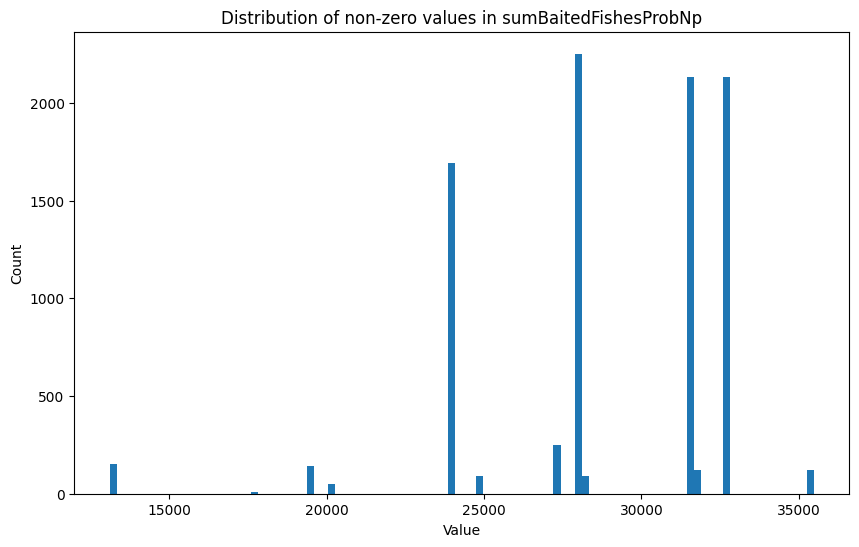

In [48]:
sumBaitedFishesProbNp = np.sum(BaitedFishesProbNp, axis=0)

maxSumProb = sumBaitedFishesProbNp.max()
plotViridis(sumBaitedFishesProbNp, material_np, maxSumProb, 20)

# 打印最大值、除去0之外的最小值，以及最大值、除去0之外的最小值的位置
print(f'最大值为{maxSumProb}')
nonZeroMin = np.min(sumBaitedFishesProbNp[sumBaitedFishesProbNp > 0])
print(f'除去0之外的最小值为{nonZeroMin}')
print(f'最大值的位置为{np.where(sumBaitedFishesProbNp == sumBaitedFishesProbNp.max())}')
print(f'除去0之外的最小值的位置为{np.where(sumBaitedFishesProbNp == nonZeroMin)}')

# 除去0之外的平均值
nonZeroMean = np.mean(sumBaitedFishesProbNp[sumBaitedFishesProbNp > 0])
print(f'除去0之外的平均值为{nonZeroMean}')

import matplotlib.pyplot as pyplt

# 画出除去0之外的值的分布曲线
pyplt.figure(figsize=(10, 6))
pyplt.hist(sumBaitedFishesProbNp[sumBaitedFishesProbNp > 0].flatten(), bins=100)
pyplt.title('Distribution of non-zero values in sumBaitedFishesProbNp')
pyplt.xlabel('Value')
pyplt.ylabel('Count')
pyplt.show()

In [49]:
# 遍历所有的饵，将以下数据放入一个dataframe中，并附加在一个xlsx的sheet后面
# 饵的名称、pond中最大实鱼权重、除去0之外的最小值、除去0之外的平均值
# 为了方便，我们先创建一个空的DataFrame
baitData = pd.DataFrame(columns=['bait_name', 'max_prob', 'non_zero_min', 'non_zero_mean'])

# 遍历所有的饵
bait_data_list = []

for bait in baitsAndLuresDf['name']:
    baitSubType = baitsAndLuresDf.loc[baitsAndLuresDf['name'] == bait, 'sub_type'].values[0]
    fishesBAITAffNp = fishToBaitAffinityDf[baitSubType].values
    fishesBAITAffNpExpanded = np.expand_dims(fishesBAITAffNp, axis=(1,2,3))
    BaitedFishesProbNp = fishesEnvProbNp * fishesBAITAffNpExpanded
    sumBaitedFishesProbNp = np.sum(BaitedFishesProbNp, axis=0)
    
    maxSumProb = sumBaitedFishesProbNp.max()
    nonZeroMin = np.min(sumBaitedFishesProbNp[sumBaitedFishesProbNp > 0])
    nonZeroMean = np.mean(sumBaitedFishesProbNp[sumBaitedFishesProbNp > 0])
    
    bait_data_list.append({
        'bait_name': bait,
        'max_prob': maxSumProb,
        'non_zero_min': nonZeroMin,
        'non_zero_mean': nonZeroMean
    })

baitData = pd.concat([baitData, pd.DataFrame(bait_data_list)], ignore_index=True)

C:\Users\futou\AppData\Local\Temp\ipykernel_19452\4061158417.py:27: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [50]:
baitData

,bait_name,max_prob,non_zero_min,non_zero_mean
0,bait_mayfly,35831.414628,11327.903357,26526.100040
1,bait_fly,35831.414628,11327.903357,26526.100040
2,bait_bloodworm,35831.414628,11327.903357,26526.100040
3,bait_shrimp,34187.607326,11822.772862,26659.456711
4,bait_crayfish,34187.607326,11822.772862,26659.456711
5,bait_grasshopper,35831.414628,11327.903357,26526.100040
6,bait_minnow,35488.235012,13106.823775,28807.750323
7,bait_fish_cube,34218.457053,13213.887931,28475.469955
8,bait_salmon_roe,34499.170691,12061.766554,27013.352377
9,bait_honey_dough,34717.418351,11545.454288,26370.767505


# 检查调试

## 看看最黑的地方是哪些鱼贡献的多

In [51]:
prob_18_14_0 = fishesEnvProbNp[:,18,14,0].astype(int)
# 以整数形式打印
fishesEnvProbNp[:,18,14,0].astype(int)

array([ 935,  276,   45,    8,  669,  165,   26,    5,  308,   81,   12,
          2,    0,  462,   71,   13,  158,   42,    7,    1,  206,   54,
          8,    1, 1136,  255,   38,    7, 2292,  601,  100,   20, 4261,
       1095,  127,  419,   70, 7102, 2130,  355,  358, 1195,   59,   12,
        781,  120, 5445, 1400,  170,   31, 4900, 1260, 1568,  224,   39,
       2581,  774,  129])

In [52]:
# Ensure prob_18_14_0 is defined
prob_18_14_0 = fishesEnvProbNp[:,18,14,0].astype(int)

# 将prob 18 14 0作为新的一列，加入fishReleaseDf，列名为prob_18_14_0
examineDf = fishReleaseDf.copy()
examineDf['prob_18_14_0'] = prob_18_14_0

# 按照prob_18_14_0列降序排列
examineDf.sort_values(by='prob_18_14_0', ascending=False, inplace=True)
examineDf

,fish_id,prob_weight_ideal,min_env_coeff,min_adapt_coeff,length_min,length_max,prob_18_14_0
37,Fish_Bowfin_Young,7500,0.0,0.0,10,30,7102
46,Fish_Pumpkinseed_Sunfish_Young,5750,0.0,0.0,10,15,5445
50,Fish_Muskellunge_Young,5750,0.0,0.0,20,60,4900
32,Fish_Redear_Sunfish_Young,4500,0.0,0.0,10,20,4261
55,Fish_Freshwater_Drum_Young,8100,0.0,0.0,10,20,2581
28,Fish_Striped_Bass_Young,3643,0.0,0.0,10,30,2292
38,Fish_Bowfin_Common,2250,0.0,0.0,30,70,2130
52,Fish_Tench_Common,1950,0.0,0.0,12,40,1568
47,Fish_Pumpkinseed_Sunfish_Common,1479,0.0,0.0,15,30,1400
51,Fish_Muskellunge_Common,1479,0.0,0.0,60,120,1260
